#  Modelling Uncertainity with Housing Data

* https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155
* https://www.databricks.com/blog/2022/04/28/how-wrong-is-your-model.html

# 1. Regular Tensorflow MLP Regression model

In [129]:
# mlp for regression
from numpy import sqrt
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import MaxPooling1D

# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(path, header=None)
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]
# X, y =df.iloc[:,12], df.values[:, -1]


# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Dense(50, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
# model.add(MaxPooling1D(2))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse')
# fit the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
# make a prediction
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
yhat = model.predict([row])
print('Predicted: %.3f' % yhat)

(339, 13) (167, 13) (339,) (167,)
MSE: 37.634, RMSE: 6.135
1/1 [==============================] - 0s 108ms/step
Predicted: 36.131


# 2. Tensorflow Probability

In [101]:
#@title Import { display-mode: "form" }

import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

In [102]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [122]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = pd.read_csv(path)#, header=None)
#print(df)
# x, y = df.values[:, :-1], df.values[:, -1]
x1 = df.iloc[:,12]
x = np.array([[n] for n in x1])
# x1 = df.iloc[:, [0,1,2]]
# print(x1)

y = df.values[:, -1]

x_train, x_tst, y_train, y_tst = train_test_split(x, y, test_size=0.33)
# print(x_tst)

     0.00632  18.00  2.310
0    0.02731    0.0   7.07
1    0.02729    0.0   7.07
2    0.03237    0.0   2.18
3    0.06905    0.0   2.18
4    0.02985    0.0   2.18
..       ...    ...    ...
500  0.06263    0.0  11.93
501  0.04527    0.0  11.93
502  0.06076    0.0  11.93
503  0.10959    0.0  11.93
504  0.04741    0.0  11.93

[505 rows x 3 columns]


In [106]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [107]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [108]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [109]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-1.6325103e+00  4.8055973e+01  4.1846107e+01  6.6401123e+01
 -4.2588320e+00 -6.2057704e-01 -2.0947132e+00  5.6832232e-02]
[-1.6425266 47.728428  41.878735  65.941826 ]


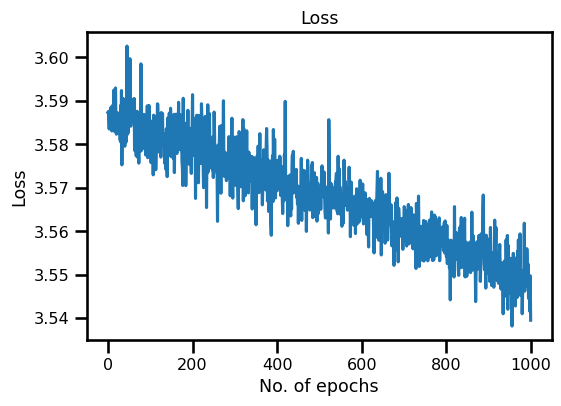

In [127]:
# Get the model
# Fit
history = model.fit(x_train, y_train, epochs=1000, verbose=0)

# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

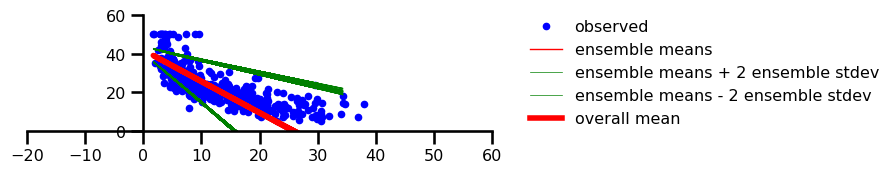

In [117]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,60);
# plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('tmp/housing.png', bbox_inches='tight', dpi=300)

In [118]:
df = pd.DataFrame({'A':[1,2,3],
                   'B':[4,5,6],
                   'C':[7,8,9],
                   'D':[1,3,5],
                   'E':[5,3,6],
                   'F':[7,4,3]})

print (df)
print(df.iloc[:,1])
   
# X = df.iloc[:, :-1].values
# print (X)
# print (X.shape)

   A  B  C  D  E  F
0  1  4  7  1  5  7
1  2  5  8  3  3  4
2  3  6  9  5  6  3
0    4
1    5
2    6
Name: B, dtype: int64
